In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import os
import cv2
import time
import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!tar -xf /content/drive/MyDrive/OCT2017.tar.gz 

In [3]:
# Model parameters
image_size = 224
batch_size = 32
num_classes = 4
channels = 3
# image_arr_size= img_width * img_height * channels

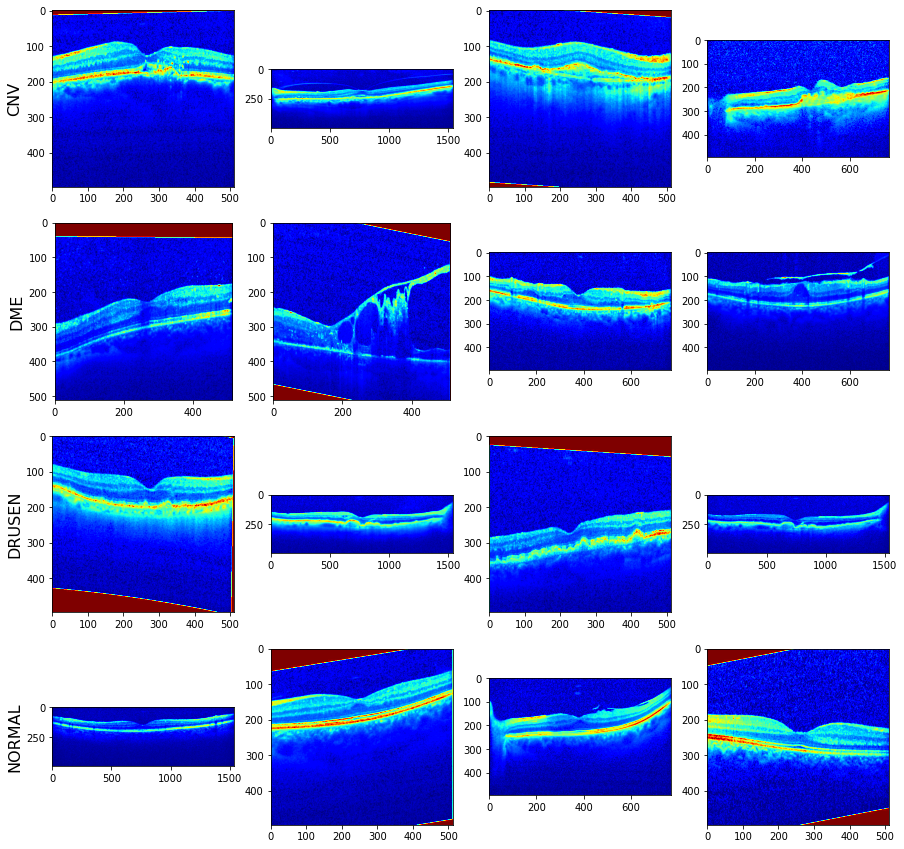

In [4]:
# sneak at the data

train_path = r'/content/OCT2017/train/'

test_path = r'/content/OCT2017/test/'

classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']


cnv_examples = glob.glob(train_path + 'CNV/*')
dme_examples = glob.glob(train_path + 'DME/*')
drusen_examples = glob.glob(train_path + 'DRUSEN/*')
normal_examples = glob.glob(train_path + 'NORMAL/*')

examples = cnv_examples[:4] + dme_examples[:4] + drusen_examples[:4] + normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='jet')
plt.show()

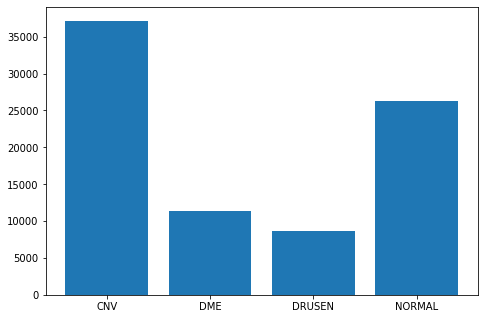

In [5]:
# Imbalance Graph

total_cnv_samples = len(glob.glob(train_path + 'CNV/*'))
total_dme_samples = len(glob.glob(train_path + 'DME/*'))
total_drusen_samples = len(glob.glob(train_path + 'DRUSEN/*'))
total_normal_samples = len(glob.glob(train_path + 'NORMAL/*'))

sample_distribution = [total_cnv_samples, total_dme_samples, total_drusen_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.show()

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory('/content/OCT2017/train',target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory('/content/OCT2017/train',target_size=(image_size,image_size),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation') # set as validation data


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory("/content/OCT2017/test",target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


{0: 1.0, 1: 3.2783346183500384, 2: 4.318003771942551, 3: 1.4138324149724493}
[1.         3.27833462 4.31800377 1.41383241]


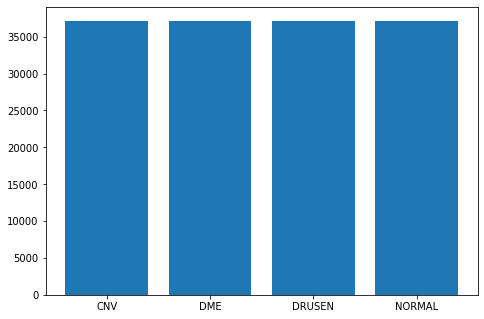

In [50]:
# Class balancing
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

# It does not increase the samples but assign weights to each class which is passed to model.fit to avoid any bias via unbalanced data

cls_wghts = np.fromiter(class_weights.values(), dtype=float)
print(cls_wghts)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution*cls_wghts)
plt.show()


VGG16 CNN architecture is used for calssification.
Pretrained on the 'ImageNet' dataset.

In [51]:
vgg16 = VGG16(include_top= False, input_shape= (image_size, image_size, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [52]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

VGG16 Architecture

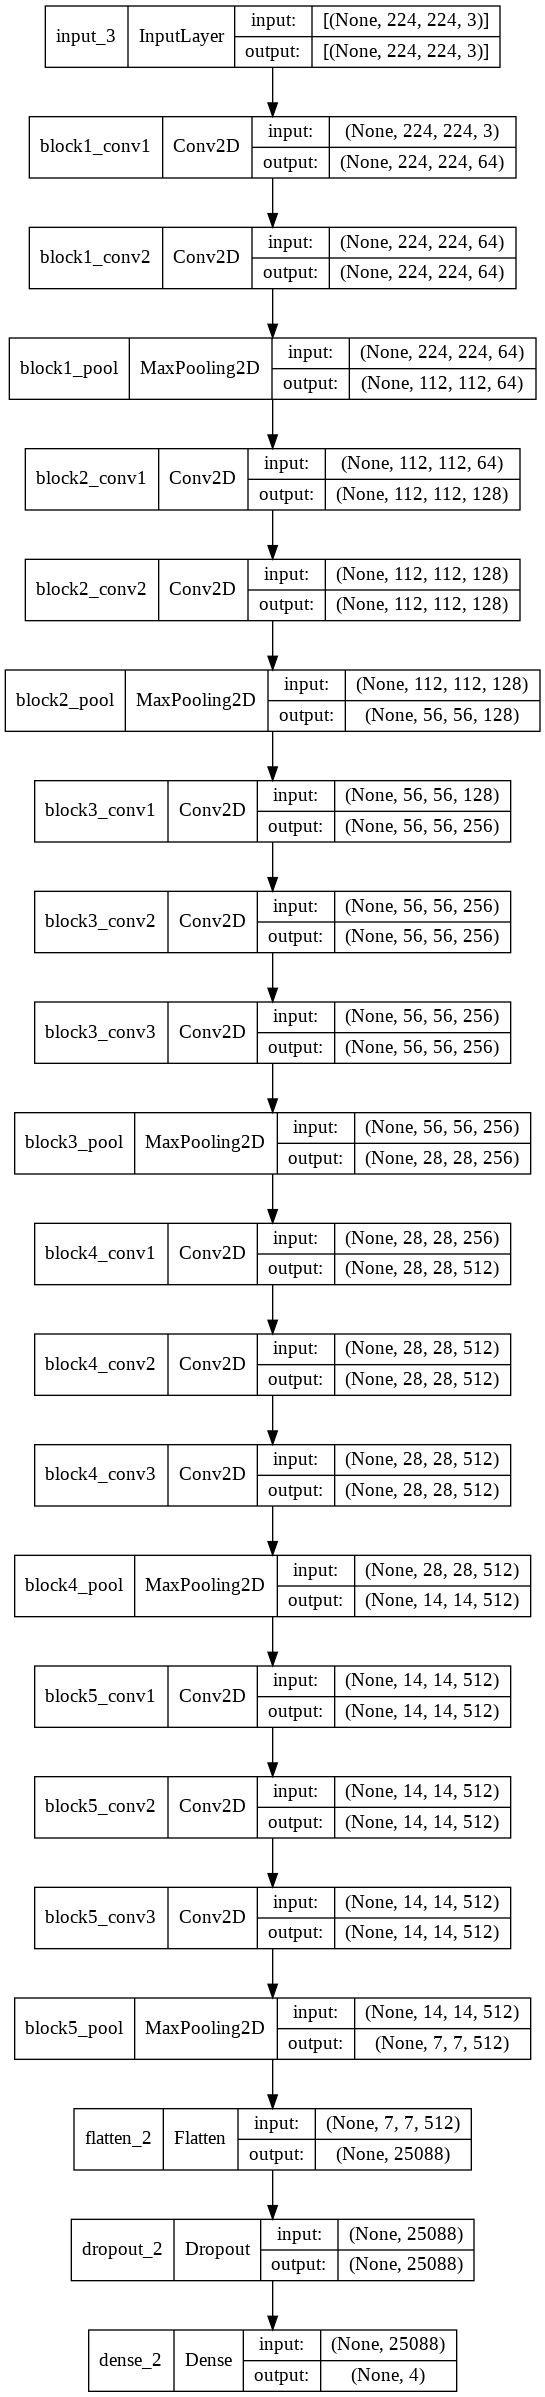

In [53]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [54]:
model.compile(optimizer= keras.optimizers.Adam(), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [55]:
history = model.fit_generator(
    train_generator, 
    epochs = 10,
    #steps_per_epoch = nb_train_samples//batch_size,
    steps_per_epoch = 200,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples//100,
    class_weight=class_weights,
    verbose = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
200/200 [==============================] - 74s 369ms/step - loss: 0.7094 - accuracy: 0.7373 - val_loss: 0.4780 - val_accuracy: 0.8309
Epoch 2/10
200/200 [==============================] - 54s 272ms/step - loss: 0.4961 - accuracy: 0.8275 - val_loss: 0.3715 - val_accuracy: 0.8684
Epoch 3/10
200/200 [==============================] - 54s 271ms/step - loss: 0.4624 - accuracy: 0.8339 - val_loss: 0.3795 - val_accuracy: 0.8673
Epoch 4/10
200/200 [==============================] - 55s 273ms/step - loss: 0.4266 - accuracy: 0.8506 - val_loss: 0.4578 - val_accuracy: 0.8341
Epoch 5/10
200/200 [==============================] - 54s 272ms/step - loss: 0.3892 - accuracy: 0.8598 - val_loss: 0.3835 - val_accuracy: 0.8641
Epoch 6/10
200/200 [==============================] - 55s 276ms/step - loss: 0.4285 - accuracy: 0.8514 - val_loss: 0.4832 - val_accuracy: 0.8447
Epoch 7/10
200/200 [==============================] - 54s 269ms/step - loss: 0.4194 - accuracy: 0.8569 - val_loss: 0.3981 - val_ac

In [58]:
#save model 

model.save("/content/drive/MyDrive/Vgg16.hdf5")

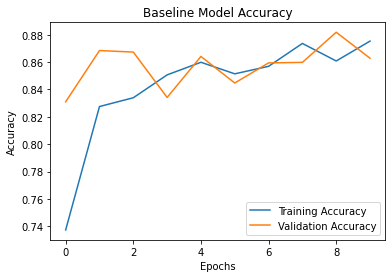

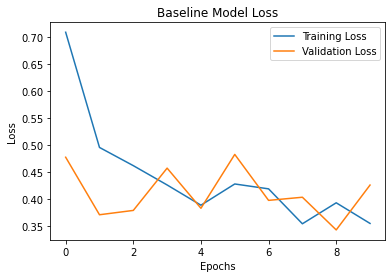

In [56]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [57]:
score = model.evaluate_generator(test_generator,steps = test_generator.samples // 100, verbose= 1) 
print("\n\n")
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


10/10 [==============================] - 1s 128ms/step - loss: 0.3003 - accuracy: 0.9156



Test Loss: 0.30031707882881165
Test accuracy: 0.9156249761581421


In [59]:
pred_datagen = ImageDataGenerator(rescale=1./255)

pred_generator = pred_datagen.flow_from_directory("/content/OCT2017/test",target_size=(image_size, image_size),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle = False)  

Found 1000 images belonging to 4 classes.


In [60]:
pred_generator.reset()
y_pred = model.predict(pred_generator,steps = 1000)
Y_test = pred_generator.classes[pred_generator.index_array]
Y_pred = np.argmax(y_pred, axis=-1)

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

--------------------
| Confusion Matrix |
--------------------

 [[248   1   1   0]
 [ 23 179  24  24]
 [ 18   0 231   1]
 [  0   0   2 248]]


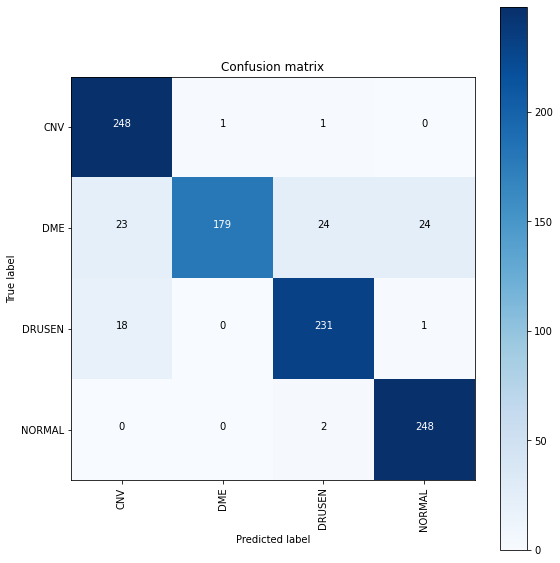

In [62]:
# confusion matrix
import itertools

cm = confusion_matrix(Y_test, Y_pred)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
        
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [63]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,target_names=['CNV','DME','DRUSEN','Normal']))

              precision    recall  f1-score   support

         CNV       0.86      0.99      0.92       250
         DME       0.99      0.72      0.83       250
      DRUSEN       0.90      0.92      0.91       250
      Normal       0.91      0.99      0.95       250

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.90      1000
weighted avg       0.91      0.91      0.90      1000

